# Loading Data

In [291]:
!pip install scikit-learn -q
!pip install category_encoders -q
!pip install ucimlrepo -q

In [292]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [293]:
bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets['y']

Делим выборку на train и test.


In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

# Exploratory Data Analysis

In [295]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
44059,37,blue-collar,married,secondary,no,195,yes,no,NaN,1,jul,10,1,-1,0,NaN
43984,37,admin.,divorced,secondary,no,450,yes,yes,NaN,24,jun,15,1,-1,0,NaN
36608,44,blue-collar,single,secondary,no,25,yes,no,cellular,12,may,244,3,-1,0,NaN
26978,39,blue-collar,single,secondary,no,4619,no,no,cellular,21,nov,104,1,-1,0,NaN
29496,29,admin.,divorced,secondary,no,120,no,yes,cellular,3,feb,197,1,-1,0,NaN


In [296]:
y_train.sample(5)

15334    no
31667    no
18681    no
40657    no
7358     no
Name: y, dtype: object

## Target

Заменяем значения целевой переменной на 0 и 1.

In [297]:
y_train = y_train.map({'no' : 0, 'yes' : 1})
y_test = y_test.map({'no' : 0, 'yes' : 1})

In [298]:
y_train.sample(5)

3983     0
23923    0
45206    1
16504    0
33073    0
Name: y, dtype: int64

## Age

Проверим на отсутствие незаполненных полей.

In [299]:
X['age'].isna().any()

False

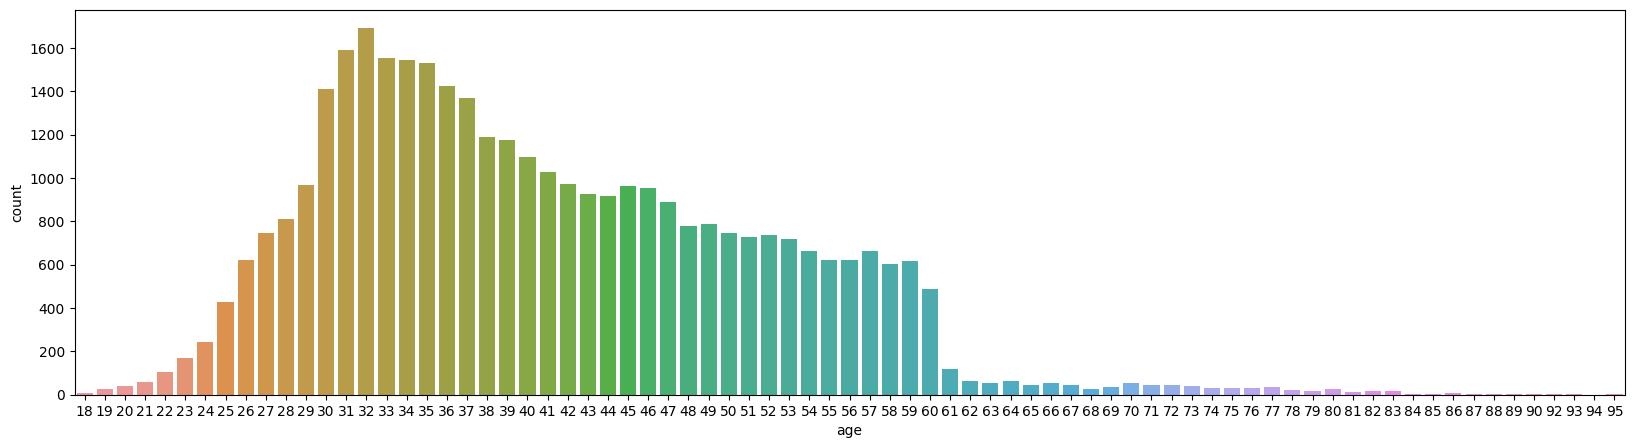

In [300]:
fig = plt.figure(figsize=(20, 5))
sns.countplot(data=X_train, x='age');

Нарисуем график зависимости среднего значения целевой переменной от возраста.

In [301]:
def mean_target_by_feature(feature_column):
    mean_target = pd.concat([feature_column, y_train], axis=1).groupby(feature_column.name, as_index=False).mean()
    return sns.lineplot(x=mean_target.iloc[:, 0], y=mean_target.iloc[:, 1])

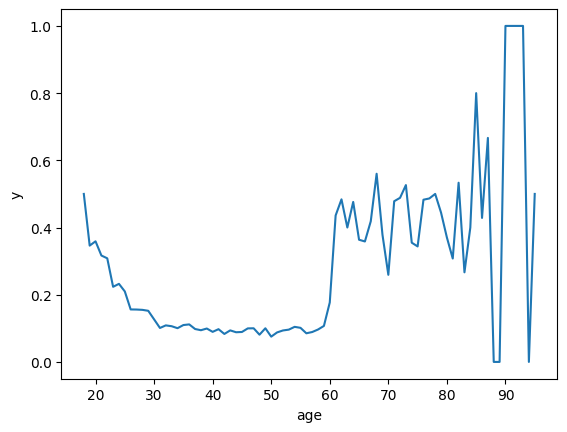

In [302]:
mean_target_by_feature(X_train['age']);

Линейной зависимости не наблюдается. Попробуем решить эту проблему.

Сгруппируем значения признака 'age' по десяткам лет (0-9, 10-19 и т.д.), $x$ → $x$ // 10 = $x'$. Теперь сформируем новый признак new_age_feature, который будет равняться $\frac{1}{30}(x')^2 - \frac{8}{30}x' + \frac{19}{30}$. Ниже виден график зависимости доли успехов ($y=1$) от признака new_age_feature. Теперь зависимость на графике близка к линейной.  

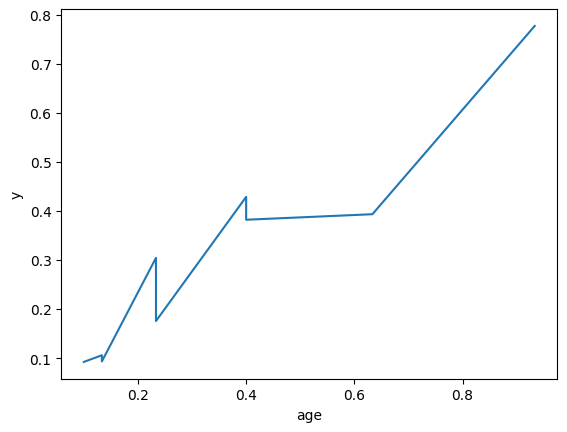

In [303]:
new_age_feature = (X_train['age'] // 10) ** 2 / 30 - 8 * (X_train['age'] // 10) / 30 + 19 / 30
mean_target_by_feature(new_age_feature);

Заменяем признак 'age' на 'new_age_feature'.

In [304]:
X_train['age'] = new_age_feature
X_test['age'] = (X_test['age'] // 10) ** 2 / 30 - 8 * (X_test['age'] // 10) / 30 + 19 / 30

## Job

Посчитаем количество пропущенных значений

In [305]:
X['job'].isna().sum()

288

В признаке 'job' оказалось всего 288 незаполненных полей, что составляет около 0.05% от =датасета, что позволяет нам выбросить строки с пропущенными значениями в столбце 'job'.

In [306]:
y_train = y_train[pd.notna(X_train['job'])]
y_test = y_test[pd.notna(X_test['job'])]
X_train = X_train[pd.notna(X_train['job'])]
X_test = X_test[pd.notna(X_test['job'])]

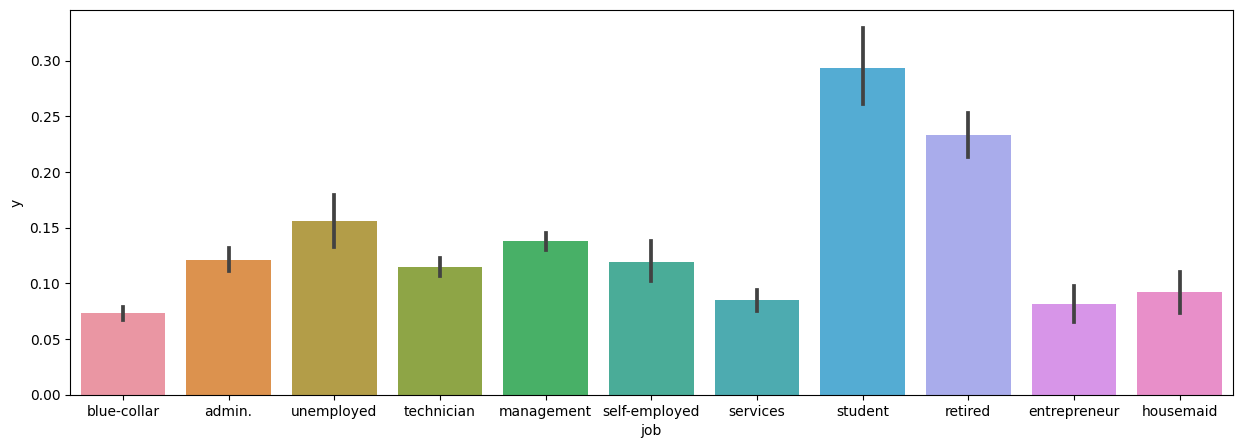

In [307]:
fig = plt.figure(figsize=(15, 5))
sns.barplot(x=X_train['job'], y=y_train);

## Marital

In [308]:
X['marital'].isna().any()

False

Нет незаполненных полей.

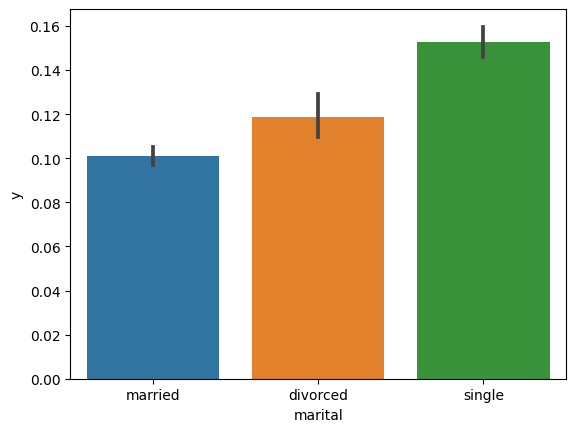

In [309]:
sns.barplot(x=X_train['marital'], y=y_train);

На диаграмме выше видим распределение среднего значения целевой переменной по всем возможным статусам поля 'marital'.

## Education

In [310]:
X['education'].value_counts(dropna=False)

secondary    23202
tertiary     13301
primary       6851
NaN           1857
Name: education, dtype: int64

Убедились, что присутствуют незаполненные поля. На диаграмме слева снизу видим распределение среднего значения y в зависимости от значения 'education'. Воспользуемся одним из способов обработки пропущенных значений: заменим пропуски самым часто встречающимся значением 'tertiary'.

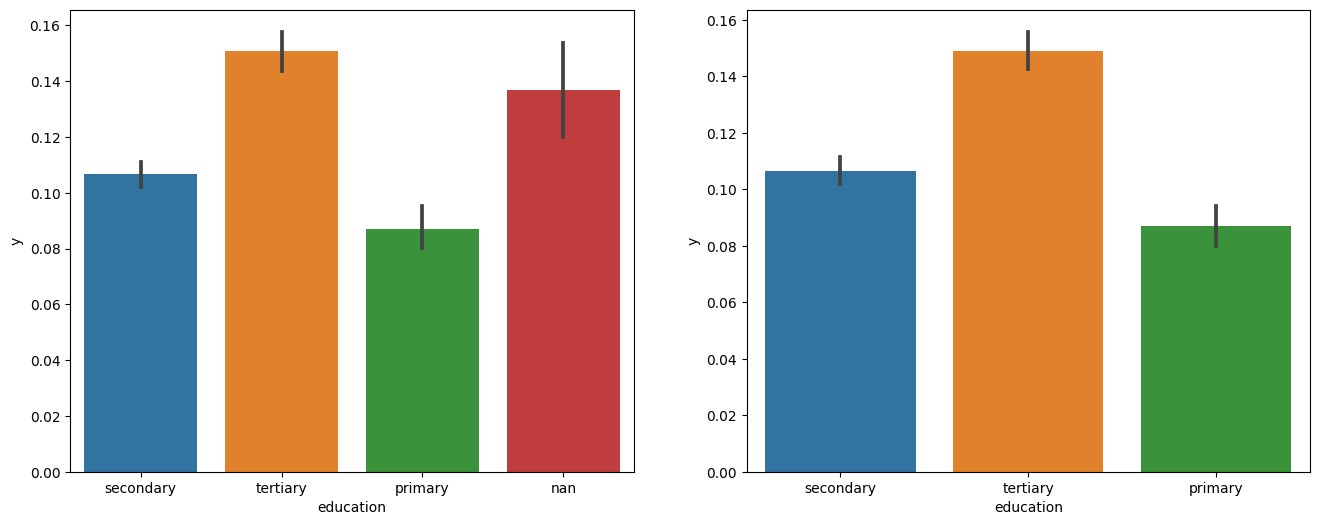

In [311]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=X_train['education'].fillna('nan'), y=y_train);
plt.subplot(1, 2, 2)
sns.barplot(x=X_train['education'].fillna('tertiary'), y=y_train);

Как мы можем увидеть, после произведенных изменений распределение среднего значения целевой переменной по признакам почти не изменилось.

Однако мы теряем информацию о том, в каких записях изначально было пропущено значение в столбце 'education'. Поэтому добавим соответствующий признак, сообщающий нам о том, было ли изначально пропущено значение.

In [312]:
X_train['nan_education'] = X_train['education'].map(lambda x: 1 if pd.isna(x) else 0)
X_train['education'] = X_train['education'].fillna('tertiary')
X_test['nan_education'] = X_test['education'].map(lambda x: 1 if pd.isna(x) else 0)
X_test['education'] = X_test['education'].fillna('tertiary')

## Default

In [313]:
X['default'].isna().sum()

0

In [314]:
X_train['default'] = X_train['default'].map({'no' : 0, 'yes' : 1})
X_test['default'] = X_test['default'].map({'no' : 0, 'yes' : 1})

Nan отсутствуют, преобразуем значения из текста в числа и выведем результат на диаграмму.

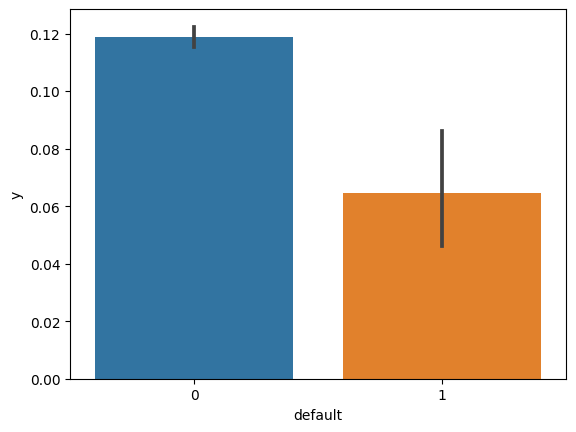

In [315]:
sns.barplot(x=X_train['default'], y=y_train);

## Balance

In [316]:
X['balance'].isna().any()

False

Нет незаполненных ячеек.

In [317]:
X_train['balance'].describe()

count     35929.000000
mean       1366.773414
std        3034.491033
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1430.000000
max      102127.000000
Name: balance, dtype: float64

In [318]:
X_train[X_train['balance'] > 10000].shape[0] / X_train[X_train['balance'] < 10000].shape[0]

0.01906004481379584

Т.к. людей со среднегодовым балансом >10000 лишь 2% от всего датасета, будем считать их чем-то по типу выбросов. Назовём этих людей богатыми ('rich') и заменим для них значения 'balance' следующим образом: сделаем их равными ровно 10000, но чтобы не потерять данные, введём признак 'rich', который равен 1, если до преобразований их 'balance' был больше 10000, иначе 0.

Сравним изначальное и обновленное распределения значений признака.

<Axes: xlabel='balance', ylabel='Count'>

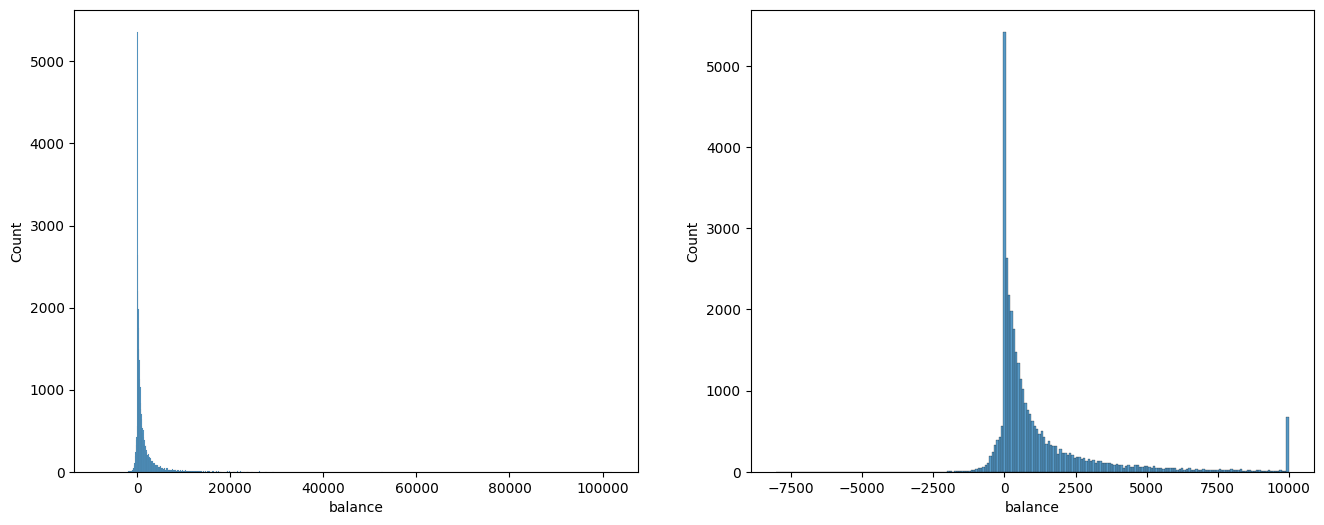

In [319]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_train['balance'])
plt.subplot(1, 2, 2)
sns.histplot(X_train['balance'].map(lambda x: 10000 if x > 10000 else x))

In [320]:
X_train['rich'] = X_train['balance'].map(lambda x: 1 if x > 10000 else 0)
X_train['balance'] = X_train['balance'].map(lambda x: 10000 if x > 10000 else x)
X_test['rich'] = X_test['balance'].map(lambda x: 1 if x > 10000 else 0)
X_test['balance'] = X_test['balance'].map(lambda x: 10000 if x > 10000 else x)

## Housing

In [321]:
X['housing'].isna().any()

False

In [322]:
X_train['housing'] = X_train['housing'].map({'no' : 0, 'yes' : 1})
X_test['housing'] = X_test['housing'].map({'no' : 0, 'yes' : 1})

Проверили на отсутствие незаполненности, преобразовали текстовые данные из колонки 'housing' в числовые, выведем итог на диаграмме.

<Axes: xlabel='housing', ylabel='y'>

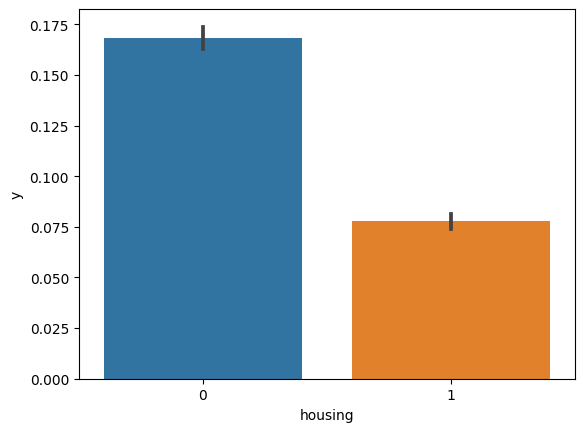

In [323]:
sns.barplot(x=X_train['housing'], y=y_train)

## Day_of_week

Проверим столбец на пропущенные значения

In [324]:
X['day_of_week'].isna().any()

False

Посмотрим на характеристики распределения признака

In [325]:
X['day_of_week'].describe()

count    45211.000000
mean        15.806419
std          8.322476
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day_of_week, dtype: float64

<Axes: xlabel='day_of_week', ylabel='y'>

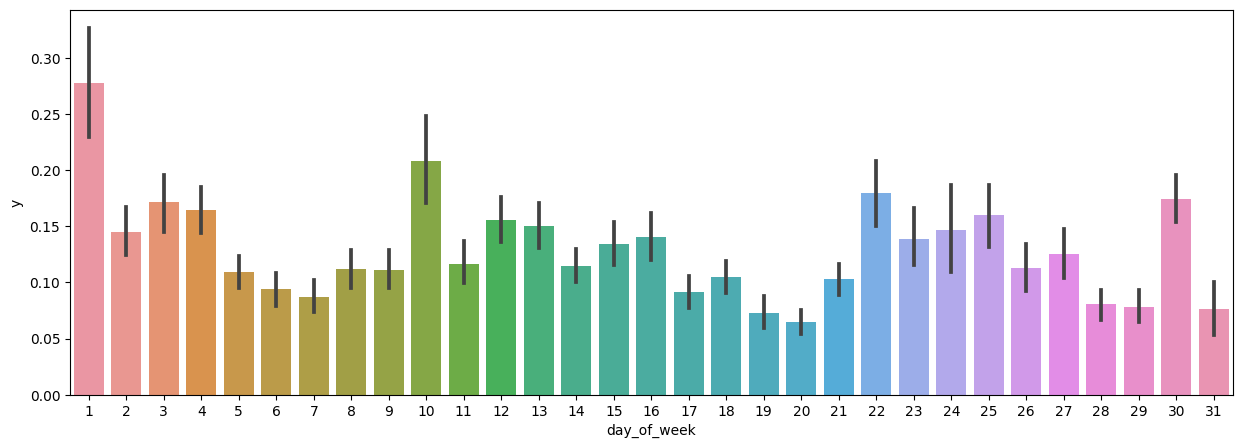

In [326]:
fig = plt.figure(figsize=(15, 5))
sns.barplot(x=X_train['day_of_week'], y=y_train)

Как мы можем заметить, данный признак по ошибке назван числовым, т.к. это просто номер дня в месяце, что куда разумнее трактовать как признак категориальный.

Ввиду большого количества различных значений признака, используем Mean Target Encoding вместо One-Hot Encoding, чтобы не добавлять 30 новых признаков.

In [327]:
target_enc = TargetEncoder()
X_train['day_of_week'] = target_enc.fit_transform(X_train['day_of_week'].map(str), y_train)
X_test['day_of_week'] = target_enc.transform(X_test['day_of_week'].map(str))

## Month

In [328]:
X['month'].isna().any()

False

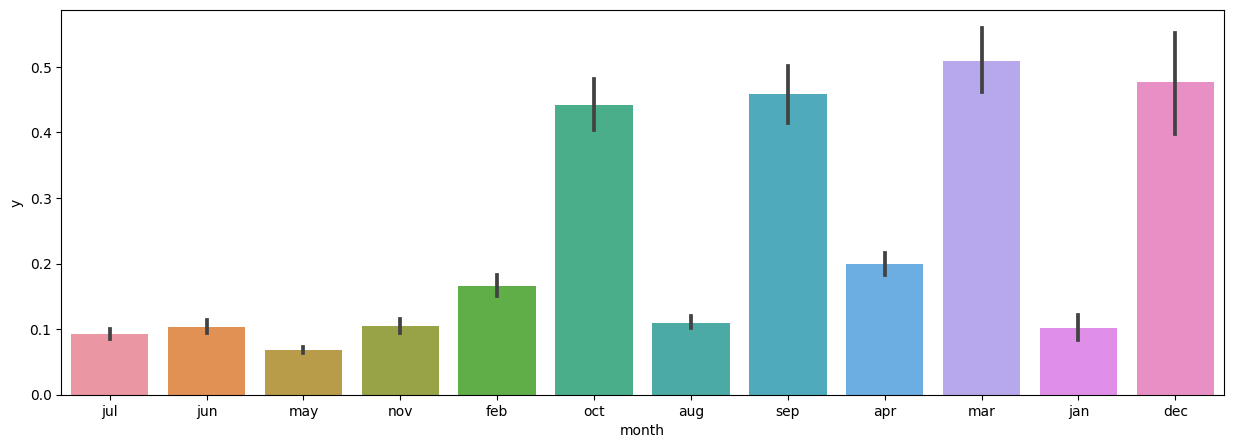

In [329]:
fig = plt.figure(figsize=(15, 5))
sns.barplot(x=X_train['month'], y=y_train);

Аналогично предыдущему признаку используем Mean Target Encoding вместо One-Hot Encoding, ввиду большого количества различных значений признака.

In [330]:
target_enc_month = TargetEncoder()
X_train['month'] = target_enc_month.fit_transform(X_train['month'].map(str), y_train)
X_test['month'] = target_enc_month.transform(X_test['month'].map(str))

## Loan

In [331]:
X['loan'].isna().any()

False

In [332]:
X_train['loan'] = X_train['loan'].map({'no' : 0, 'yes' : 1})
X_test['loan'] = X_test['loan'].map({'no' : 0, 'yes' : 1})

Нет Nan-ов, преобразовали текстовые данные из колонки 'loan' в числовые, выведем итог на диаграмме.

<Axes: xlabel='loan', ylabel='y'>

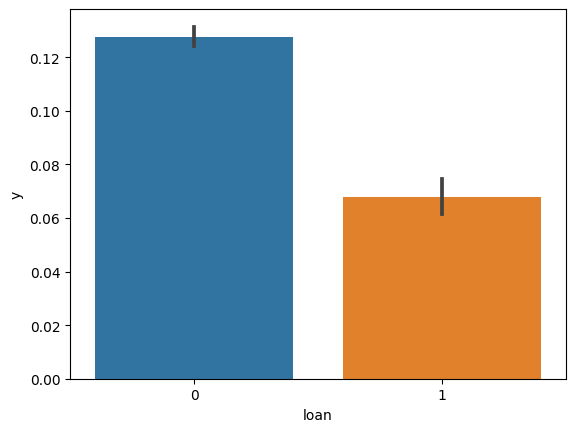

In [333]:
sns.barplot(x=X_train['loan'], y=y_train)

## Contact

In [334]:
X['contact'].value_counts(dropna=False)

cellular     29285
NaN          13020
telephone     2906
Name: contact, dtype: int64

<Axes: xlabel='contact', ylabel='y'>

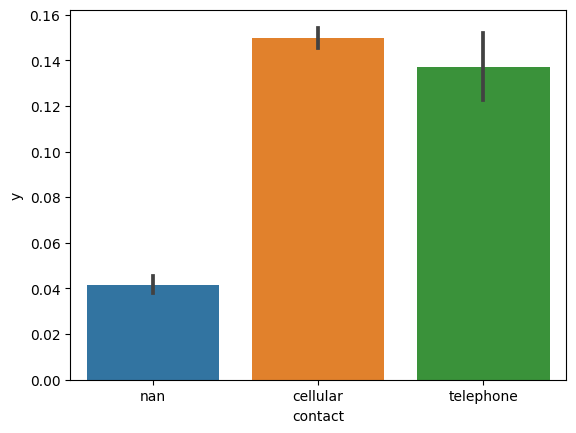

In [335]:
sns.barplot(x=X_train['contact'].fillna('nan'), y=y_train)

Как мы можем увидеть, среднее значение целевой переменной сильно зависит от того, является значение признака 'contact' пропущенным или нет, в связи с чем закодируем пропущенное значение как отдельное значение признака.

In [336]:
X_train['contact'] = X_train['contact'].fillna('unknown')
X_test['contact'] = X_test['contact'].fillna('unknown')

## Campaign

In [337]:
X['campaign'].isna().any()

False

In [338]:
X_train['campaign'].describe()

count    35929.000000
mean         2.767987
std          3.085041
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         58.000000
Name: campaign, dtype: float64

In [339]:
X_train[X_train['campaign'] >= 30].shape[0]

54

Назовем выбросами те образцы, у которых поле 'campaign' больше 30, т.к. таких полей всего 54 и выбросим их из тренировочной выборки. Агрегируем значения признака следующим образом: X['campaign'] // 5, выведем на графике соответствующие группам средние значения целевой переменной, получаем что-то похожее на линейную зависимость.

In [340]:
y_train = y_train[X_train['campaign'] < 30]
X_train = X_train[X_train['campaign'] < 30]

<Axes: xlabel='campaign', ylabel='y'>

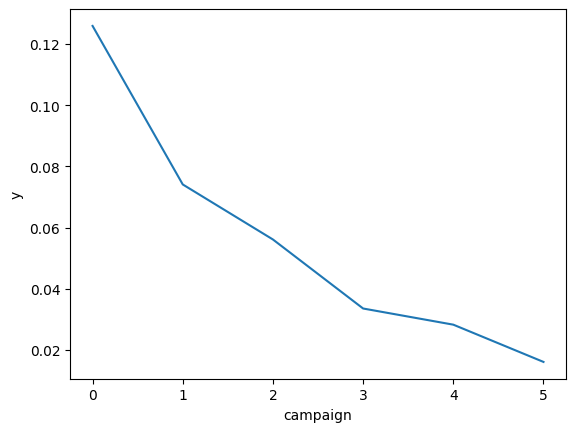

In [341]:
mean_target_by_feature(X_train['campaign'] // 5)

In [342]:
X_train['campaign'] = X_train['campaign'] // 5
X_test['campaign'] = X_test['campaign'] // 5

## Pdays

In [343]:
X['pdays'].isna().any()

False

## Previous

In [344]:
X['previous'].isna().any()

False

## Poutcome

In [345]:
X['poutcome'].isna().sum()

36959

Заметим, что в признаке 'poutcome' большое число незаполненных полей, поэтому, чтобы не терять информацию, будем воспринимать их как отдельное значение признака 'poutcome'.

<Axes: xlabel='poutcome', ylabel='y'>

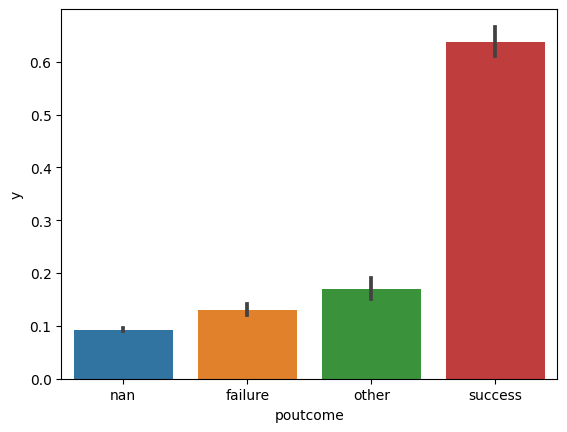

In [346]:
sns.barplot(x=X_train['poutcome'].fillna('nan'), y=y_train)

In [347]:
X_train['poutcome'] = X_train['poutcome'].fillna('unknown')
X_test['poutcome'] = X_test['poutcome'].fillna('unknown')

## Duration

Выбросим данный столбец в связи с тем, что в описании датасета указано следующее: "Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model."

In [348]:
X_train.drop(columns=['duration'], inplace=True)
X_test.drop(columns=['duration'], inplace=True)

## Final Encoding

In [349]:
X_train.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,nan_education,rich
44059,0.133333,blue-collar,married,secondary,0,195,1,0,unknown,0.278195,0.092873,0,-1,0,unknown,0,0
43984,0.133333,admin.,divorced,secondary,0,450,1,1,unknown,0.146974,0.103654,0,-1,0,unknown,0,0
36608,0.100000,blue-collar,single,secondary,0,25,1,0,cellular,0.155318,0.067824,0,-1,0,unknown,0,0
26978,0.133333,blue-collar,single,secondary,0,4619,0,0,cellular,0.102706,0.104831,0,-1,0,unknown,0,0
29496,0.233333,admin.,divorced,secondary,0,120,0,1,cellular,0.171395,0.165720,0,-1,0,unknown,0,0


In [350]:
column_transf = ColumnTransformer(transformers=
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['job', 'marital', 'contact', 'poutcome', 'education']),
    ('sca', StandardScaler(), ['age', 'balance', 'day_of_week', 'month', 'campaign', 'pdays', 'previous'])]
)

X_train = pd.DataFrame(data = column_transf.fit_transform(X_train), columns = column_transf.get_feature_names_out())
X_test = pd.DataFrame(data = column_transf.transform(X_test), columns = column_transf.get_feature_names_out())

In [351]:
X_train.head(5)

,ohe__job_blue-collar,ohe__job_entrepreneur,ohe__job_housemaid,ohe__job_management,ohe__job_retired,ohe__job_self-employed,ohe__job_services,ohe__job_student,ohe__job_technician,ohe__job_unemployed,...,ohe__poutcome_unknown,ohe__education_secondary,ohe__education_tertiary,sca__age,sca__balance,sca__day_of_week,sca__month,sca__campaign,sca__pdays,sca__previous
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-0.178478,-0.506027,4.431756,-0.301494,-0.335033,-0.411654,-0.244035
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-0.178478,-0.382196,0.802955,-0.171795,-0.335033,-0.411654,-0.244035
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-0.769916,-0.588581,1.033685,-0.602813,-0.335033,-0.411654,-0.244035
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-0.178478,1.642326,-0.421235,-0.157638,-0.335033,-0.411654,-0.244035
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.595835,-0.542448,1.478287,0.574831,-0.335033,-0.411654,-0.244035


# Logistic Regression

Для классификации мы будем использовать логистическую регрессию c l2-регуляризацией. Метрикой качества классификации будет ROC-AUC.

Первым делом при помощи перебора по сетке найдем оптимальный коэффицент регуляризации.

In [352]:
searcher = GridSearchCV(estimator=LogisticRegression(penalty='l2'), param_grid={'C': np.arange(1, 50)}, cv=5,
                        scoring='roc_auc', verbose=1)
searcher.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='roc_auc', verbose=1)

In [353]:
searcher.best_params_

{'C': 1}

Обучим логистическую регрессию с найденным гиперпараметром.

In [354]:
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train, y_train)

LogisticRegression()

Посчитаем метрики качества классификации

In [355]:
print(f'ROC-AUC на тренировочной выборке: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}')
print(f'ROC-AUC на тестовой выборке: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}')

ROC-AUC на тренировочной выборке: 0.7655774899735364
ROC-AUC на тестовой выборке: 0.7749677752791014


Определим самые важные признаки.

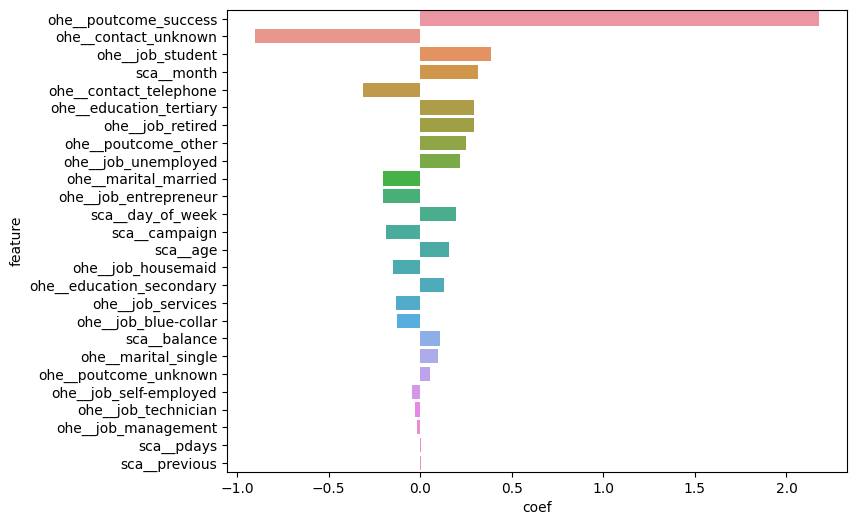

In [356]:
feature_importances = pd.DataFrame(model.coef_[0].reshape((-1, 1)), pd.Series(X_train.columns)).reset_index()
feature_importances.columns = ['feature', 'coef']
feature_importances['abs_coef'] = feature_importances['coef'].map(lambda x: abs(x))
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances.sort_values(by='abs_coef', ascending=False), x='coef', y='feature');

Самыми важными признаками оказались результат предыдущей маркетинговой компании, указан способ связи клиента или нет, является ли он студентом и в каком месяце ему предлагали оформить срочный вклад.